Case Study on GNNs with PyTorch Geometric (PyG): Cora Dataset

Social media has become popular in recent years, and users are connected to each other through followers-followers relationships. There are many other types of data that have a network structure in which data are connected to each other. One machine learning model that can be applied to such data is the graph neural networks (GNNs), which is attracting a lot of attention. In this article, we will explain the characteristics of graph data, as well as the usage of libraries and visualization techniques related to graph neural networks.

Through this notebook, one will learn the following:

1. How to handle pytorch geometric and networkx
2. Characteristics of the Cora dataset
3. How to effectively visualize data

In [ ]:
pip install networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 7.9 MB 8.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 3.5 MB 7.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 2.4 MB 10.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 709 kB 7.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/

In [ ]:
import os
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import networkx as nx
from networkx.algorithms import community
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

**Cora Dataset**

The Cora dataset is a well-known dataset in the field of graph research. This consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary which consists of 1433 unique words.

As a side note, there is a service that displays a network of papers connected by citation relations. This is very useful when looking for related studies. See [here](https://www.connectedpapers.com/) for details.

First, download the dataset by running the command below. In this article we will work with the data using pytorch geometric and networkx.

In [ ]:
dataset = Planetoid(root=data_dir, name='Cora')
data = dataset[0]

# https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/datasets/planetoid.html

**Nodes**

The Cora dataset contains 2708 papers, which are represented as nodes in the graph.

In [ ]:
print(f'Number of nodes: {data.num_nodes}')

Number of nodes: 2708


**Edges**

The papers in the Cora dataset have 5429 citation connections, which are represented as edges in the graph. The edge information is unique to graph data.

In [ ]:
print(f'Number of edges: {data.num_edges}')

Number of edges: 10556


The number of edges seems to be 10556. Let’s find out why the number of edges is twice as large as 5429.

In [ ]:
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Has isolated nodes: False
Has self-loops: False
Is undirected: True


The first line of code confirms that there are no nodes not connected by edges, the second line of code shows that there are no self-loops, and the third line of code shows that edges are not directional. This means that the edge count is double the actual count because of the bi-directional edge information included.

Let’s see how edge information is stored. Let’s look at the edge held by the 30th node as an example.

In [ ]:
edge_index = data.edge_index.numpy()
print(edge_index.shape)
edge_example = edge_index[:, np.where(edge_index[0]==30)[0]]
edge_example

(2, 10556)


array([[  30,   30,   30,   30,   30,   30],
       [ 697,  738, 1358, 1416, 2162, 2343]])

We have obtained data in the form of pairs of nodes to which the edges are connected.

Now, let’s try to draw a network centered on this node.

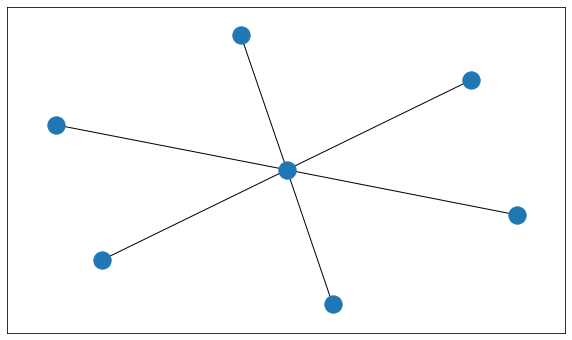

In [ ]:
node_example = np.unique(edge_example.flatten())
plt.figure(figsize=(10, 6))
G = nx.Graph()
G.add_nodes_from(node_example)
G.add_edges_from(list(zip(edge_example[0], edge_example[1])))
nx.draw_networkx(G, with_labels=False)

**Node Degree**

Degree in graph theory means the number of edges joining a vertex (node) in a graph. We saw earlier that each node always has an edge, so how many edges does each node have on average?

In [ ]:
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')

Average node degree: 3.90


We found that the average node degree is 3.9. You may have thought it was surprisingly low. We can check the overall distribution by drawing a histogram of the degree.

,count,mean,std,min,25%,50%,75%,max
0,2708.0,3.9,5.23,1.0,2.0,3.0,5.0,168.0


2708
10556


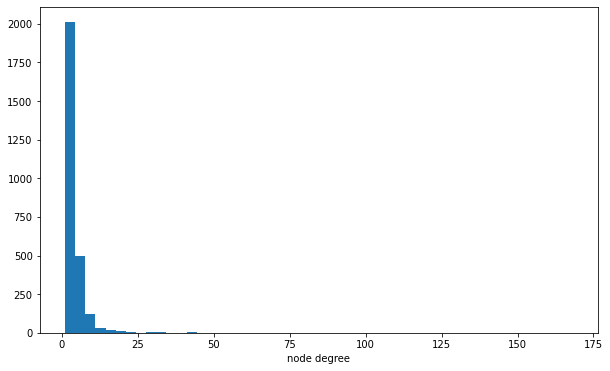

In [ ]:
G = to_networkx(data, to_undirected=True)
degrees = [val for (node, val) in G.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
print(len(degrees))
print(sum(degrees))
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50)
plt.xlabel("node degree")
plt.show()

High degree means that they are connected to many nodes (papers). In other words, nodes with high degree are likely to be important. Remember, when looking for papers, you can always infer how good or bad a paper is by looking at how many times it has been cited.

Let’s plot the graph to see where the top 10 nodes with the highest degree are located.

threshold 0.011821204285186553


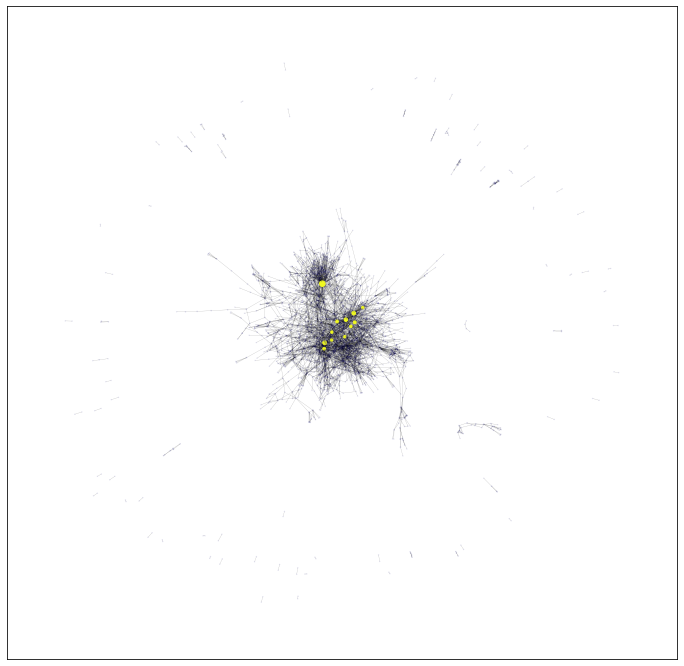

In [ ]:
G = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G, seed=42)
cent = nx.degree_centrality(G)
node_size = list(map(lambda x: x * 500, cent.values()))
cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse=True)[10]
print("threshold", threshold)
cent_bin = np.where(cent_array >= threshold, 1, 0.1)
plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
                               cmap=plt.cm.plasma,
                               node_color=cent_bin,
                               nodelist=list(cent.keys()),
                               alpha=cent_bin)
edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.3)
plt.show()

The top 10 nodes with the highest degree are represented by yellow dots, and the other nodes are represented by gray dots. The yellow dots are proportional to the size of the degree. You can see that the yellow dots are all located in the central part of the network.

Features

The papers in the Cora dataset have 1433 features.

For each of the 1433 words, the number of features is expressed as 0 and 1 if the word is included or not included in the paper.

In [ ]:
print(f'Number of features: {data.num_node_features}')

Number of features: 1433


Let’s display some of the features, and you can see that they are composed of 0s and 1s.

In [ ]:
print(len(data.x[0]))
data.x[0][:20]

1433


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1.])

Note that we are now looking at the node features. Edges may also have feature values (edge features), but they are not included in the Cora dataset.

In [ ]:
print(f'Number of edge features: {data.num_edge_features}')

Number of edge features: 0


**Classes**

The papers in the Cora dataset are labeled with 7 different labels.

In [ ]:
print(f'Number of classes: {dataset.num_classes}')

Number of classes: 7


Let’s display a portion of the class, and we can see that it consists of integers between 0 and 6. Each number corresponds to a subject as follows. See here for details.

In [ ]:
label_dict = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"}
data.y[:10]

tensor([3, 4, 4, 0, 3, 2, 0, 3, 3, 2])

Often the number of classes is not equal. Let’s find out the number of each class.

{3: 818, 4: 426, 0: 351, 2: 418, 1: 217, 5: 298, 6: 180}


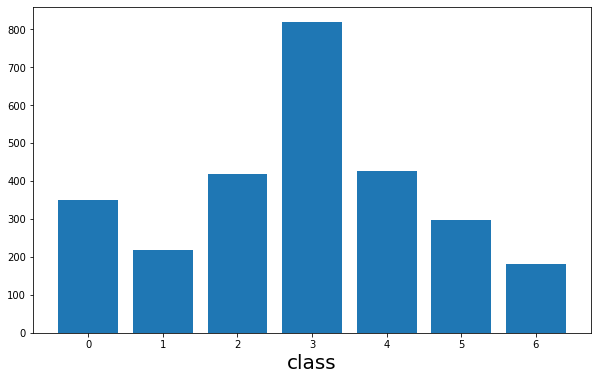

In [ ]:
counter = collections.Counter(data.y.numpy())
counter = dict(counter)
print(counter)
count = [x[1] for x in sorted(counter.items())]
plt.figure(figsize=(10, 6))
plt.bar(range(7), count)
plt.xlabel("class", size=20)
plt.show()

The highest number of classes is 818 in class 3, and the lowest number is 180 in class 6. We need to be careful when training machine learning models.

Next, draw a network diagram to see if the classes are distributed coherently.

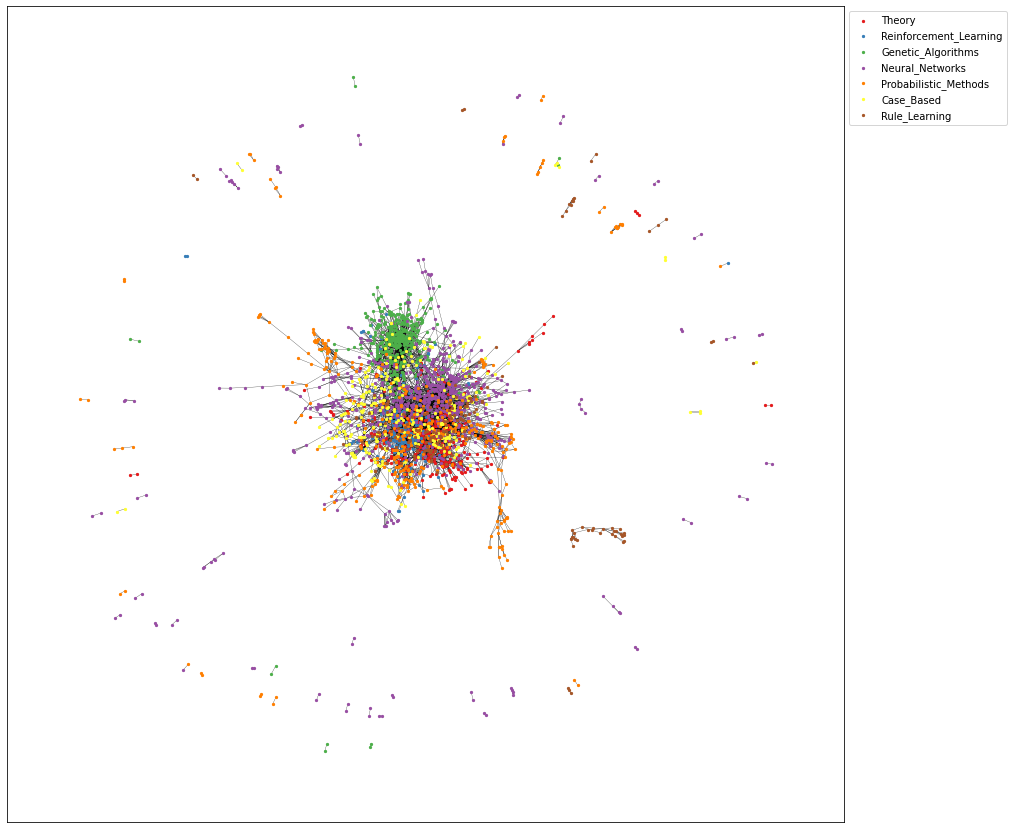

In [ ]:
G = to_networkx(data, to_undirected=True)
node_color = []
nodelist = [[], [], [], [], [], [], []]
colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']
labels = data.y
for n, i in enumerate(labels):
    node_color.append(colorlist[i])
    nodelist[i].append(n)
pos = nx.spring_layout(G, seed = 42)
plt.figure(figsize = (15, 15))
labellist = list(label_dict.values())
for num, i in enumerate(zip(nodelist, labellist)):
    n, l = i[0], i[1]
    nx.draw_networkx_nodes(G, pos, nodelist=n, node_size = 5, node_color = colorlist[num], label=l)
nx.draw_networkx_edges(G, pos, width = 0.25)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

It is a little difficult to see because it is plotted in two dimensions, but it looks as if the classes are somewhat grouped together. We will analyze this point from a different angle in the next section.


**Homophily**

Nodes with the same characteristics are often connected. This property is called homophily. For the seven classes we looked at earlier, we will see how many nodes of the same class are connected by edges and vice versa.



label: 0
1527 edges
{0: 1068, 1: 32, 3: 161, 6: 80, 5: 75, 4: 88, 2: 23}
label: 1
1029 edges
{1: 818, 3: 67, 0: 32, 5: 28, 2: 62, 4: 20, 6: 2}
label: 2
1826 edges
{2: 1654, 3: 53, 1: 62, 5: 30, 0: 23, 4: 2, 6: 2}
label: 3
2838 edges
{3: 2350, 2: 53, 4: 137, 5: 54, 0: 161, 6: 16, 1: 67}
label: 4
1592 edges
{4: 1320, 3: 137, 0: 88, 1: 20, 6: 6, 5: 19, 2: 2}
label: 5
1086 edges
{2: 30, 5: 834, 0: 75, 3: 54, 1: 28, 4: 19, 6: 46}
label: 6
658 edges
{6: 506, 5: 46, 0: 80, 4: 6, 3: 16, 1: 2, 2: 2}


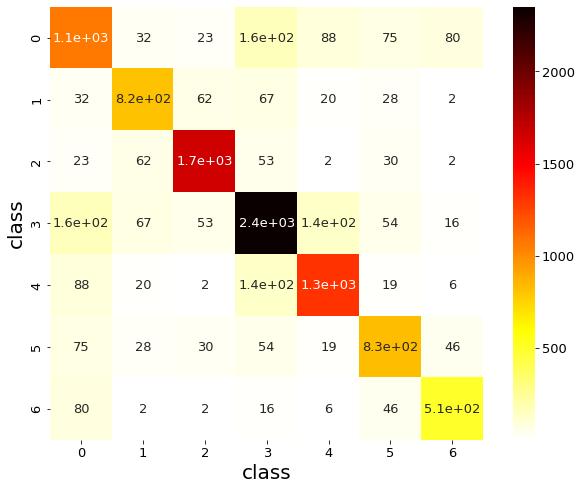

In [ ]:
labels = data.y.numpy()
connected_labels_set = list(map(lambda x: labels[x], data.edge_index.numpy()))
connected_labels_set = np.array(connected_labels_set)
def add_missing_keys(counter, classes):
    for x in classes:
        if x not in counter.keys():
            counter[x] = 0
    return counter
label_connection_counts = []
for i in range(7):
    print(f"label: {i}")
    connected_labels = connected_labels_set[:, np.where(connected_labels_set[0] == i)[0]]
    print(connected_labels.shape[1], "edges")
    counter = collections.Counter(connected_labels[1])
    counter = dict(counter)
    print(counter)
    counter = add_missing_keys(counter, range(7))
    items = sorted(counter.items())
    items = [x[1] for x in items]
    label_connection_counts.append(items)
label_connection_counts = np.array(label_connection_counts)
plt.figure(figsize=(9, 7))
plt.rcParams["font.size"] = 13
hm = sns.heatmap(label_connection_counts, annot=True, cmap='hot_r', cbar=True, square=True)
plt.xlabel("class",size=20)
plt.ylabel("class",size=20)
plt.tight_layout()
plt.show()

We can see that there are a great many nodes that are connected to each other belonging to the same class.

By dividing the sum of the diagonal components of the matrix by the sum of all components, we calculate the percentage of edges connected within the same class.

In [ ]:
label_connection_counts.diagonal().sum() / label_connection_counts.sum()

0.8099658961727927

It seems that about 81% of the edges are connected within the same class.

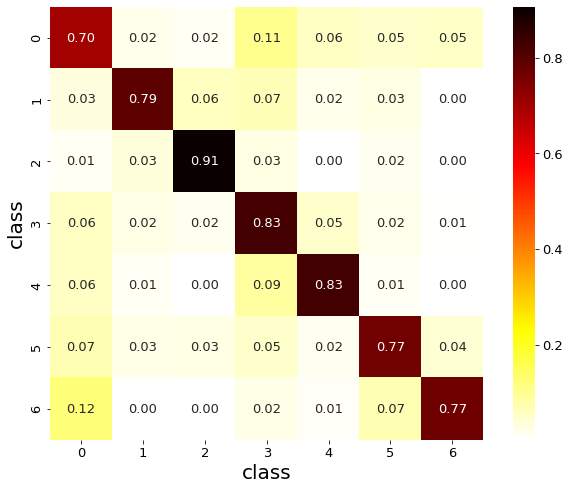

In [ ]:
def scaling(array):
    return array / sum(array)
label_connection_counts_scaled = np.apply_along_axis(scaling, 1, label_connection_counts)
plt.figure(figsize=(9, 7))
plt.rcParams["font.size"] = 13
hm = sns.heatmap(
    label_connection_counts_scaled,
    annot=True,
    cmap='hot_r',
    fmt="1.2f",
    cbar=True,
    square=True)
plt.xlabel("class",size=20)
plt.ylabel("class",size=20)
plt.tight_layout()
plt.show()

Excellent! We can see that for all classes, the highest number of edges are tied to the same class. This is also most true for Class 2, where about 91% of the edges are joined within the same class. On the other hand, the trend is relatively weak in Class 0, with about 70% of the edges being within the same class.

**Train Test Split**

Last but not least, we will discuss data splitting. The data class we are dealing with now has split information in the form of a mask, which can be divided into training data, validation data, and testing data. First, let’s see how many data each contains.

In [ ]:
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of validation nodes: {data.val_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')

Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000


The data was split into 140 training data, 500 validation data, and 1000 test data. However, the total of these does not add up to 2708 cases. Let’s check which data is used and which data is not.

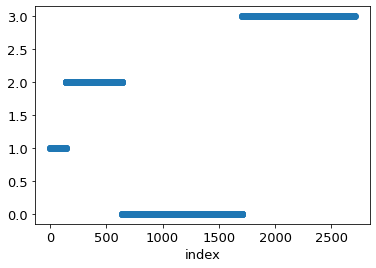

In [ ]:
split_type_array = np.zeros(data.num_nodes)
split_type_array[np.where(data.train_mask == True)[0]] = 1
split_type_array[np.where(data.val_mask == True)[0]] = 2
split_type_array[np.where(data.test_mask == True)[0]] = 3
split_type_array
plt.scatter(range(2708), split_type_array)
plt.xlabel("index")
plt.show()

We plot the x-axis as index and the y-axis as 0 for unused data, 1 for training data, 2 for validation data, and 3 for test data. It is an odd split, but it appears that the data is split as above.

Training {3: 20, 4: 20, 0: 20, 2: 20, 1: 20, 5: 20, 6: 20}
Validation {4: 81, 3: 158, 0: 61, 6: 29, 1: 36, 2: 78, 5: 57}
Test {3: 319, 2: 144, 0: 130, 1: 91, 5: 103, 4: 149, 6: 64}


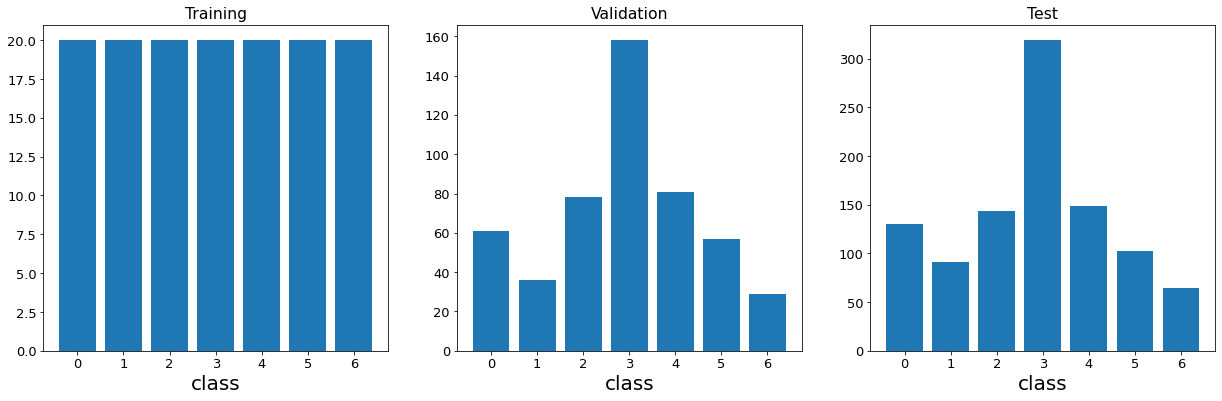

In [ ]:
titles = ["Training", "Validation", "Test"]
fig, axes = plt.subplots(ncols=3, figsize=(21, 6))

for i in range(3):
      counter = collections.Counter(data.y.numpy()[np.where(split_type_array == i + 1)[0]])
      counter = dict(counter)
      print(titles[i], counter)

      count = [x[1] for x in sorted(counter.items())]
       
      # plt.figure(figsize=(10, 6))
      axes[i].bar(range(7), count)
      axes[i].set_xlabel("class", size=20)
      axes[i].set_title(titles[i])
plt.show()



Interesting! The training data contains 20 data for each class. The validation and test data do not have equal proportions of classes, but the two have a similar distribution. And these are similar to the percentages of classes in the overall data seen in the Classes section.

**Conclusion**

In this case-study, we used the CORA dataset to explain the characteristics of data with graph structure and how to draw diagrams.